In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr

warnings.filterwarnings("ignore", module="scipy")

print(f"Running on PyMC v{pm.__version__}")

RANDOM_SEED = 8924
az.style.use("arviz-darkgrid")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.16.2


In [10]:
try:
    srrs2 = pd.read_csv(os.path.join("..", "data", "srrs2.dat"))
except FileNotFoundError:
    srrs2 = pd.read_csv(pm.get_data("srrs2.dat"))

srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

try:
    cty = pd.read_csv(os.path.join("..", "data", "cty.dat"))
except FileNotFoundError:
    cty = pd.read_csv(pm.get_data("cty.dat"))

srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

srrs_mn.county = srrs_mn.county.map(str.strip)
county, mn_counties = srrs_mn.county.factorize()
srrs_mn["county_code"] = county
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values
coords = {"county": mn_counties}

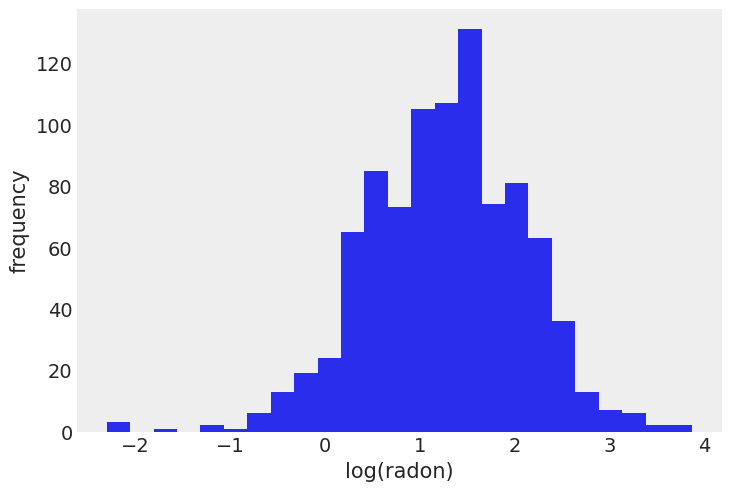

In [11]:
srrs_mn.log_radon.hist(bins=25, grid=False)
plt.xlabel("log(radon)")
plt.ylabel("frequency");

# Conventional Approaches

- Pooled Model

/Users/mori/GIT/forMori/BayesianInference/basecamp/.venv/lib/python3.12/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Sampling: [alpha, beta, sigma, y]


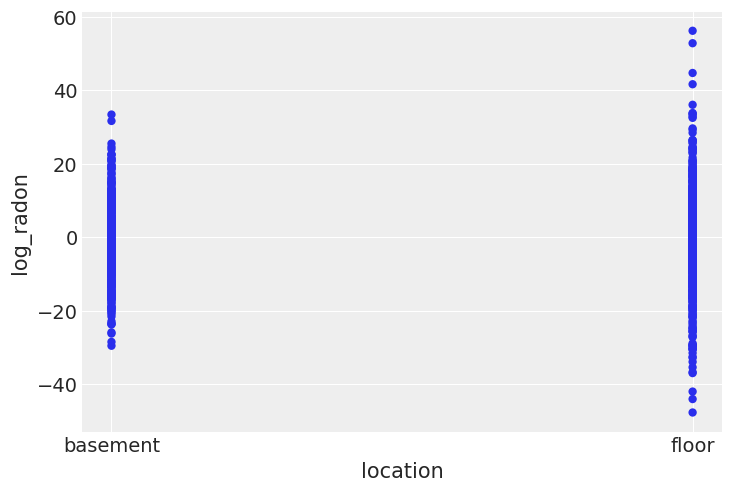

In [12]:
with pm.Model() as pooled_model:
    floor_ind = pm.MutableData("floor_ind", floor_measure, dims="obs_id")

    alpha = pm.Normal("alpha", 0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.Exponential("sigma", 5)

    theta = alpha + beta * floor_ind

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

with pooled_model:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

prior = prior_checks.prior.squeeze(drop=True)

xr.concat((prior["alpha"], prior["alpha"] + prior["beta"]), dim="location").rename(
    "log_radon"
).assign_coords(location=["basement", "floor"]).plot.scatter(
    x="location", y="log_radon", edgecolors="none"
);

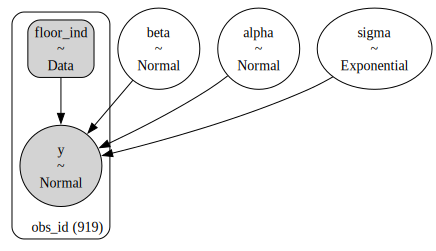

In [17]:
pm.model_to_graphviz(pooled_model)

In [4]:
with pooled_model:
    pooled_trace = pm.sample(random_seed=RANDOM_SEED)
az.summary(pooled_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

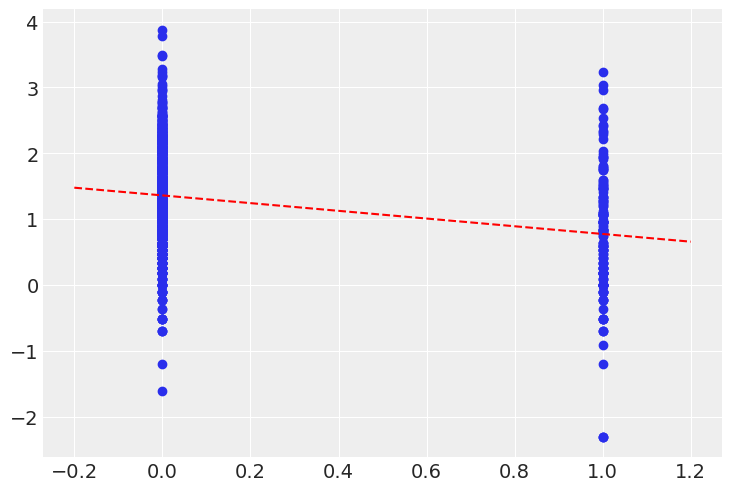

In [6]:
post_mean = pooled_trace.posterior.mean(dim=("chain", "draw"))

plt.scatter(srrs_mn.floor, np.log(srrs_mn.activity + 0.1))
xvals = xr.DataArray(np.linspace(-0.2, 1.2))
plt.plot(xvals, post_mean["beta"] * xvals + post_mean["alpha"], "r--");

- Unpooled Model

In [7]:
with pm.Model(coords=coords) as unpooled_model:
    floor_ind = pm.MutableData("floor_ind", floor_measure, dims="obs_id")

    alpha = pm.Normal("alpha", 0, sigma=10, dims="county")
    beta = pm.Normal("beta", 0, sigma=10)
    sigma = pm.Exponential("sigma", 1)

    theta = alpha[county] + beta * floor_ind

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

/opt/homebrew/anaconda3/envs/BayesianInference/lib/python3.10/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


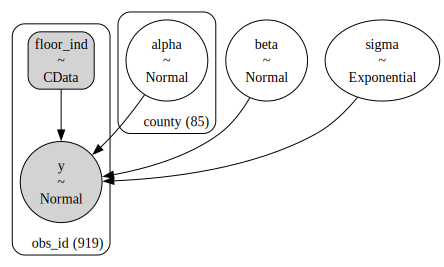

In [8]:
pm.model_to_graphviz(unpooled_model)

In [9]:
with unpooled_model:
    unpooled_trace = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


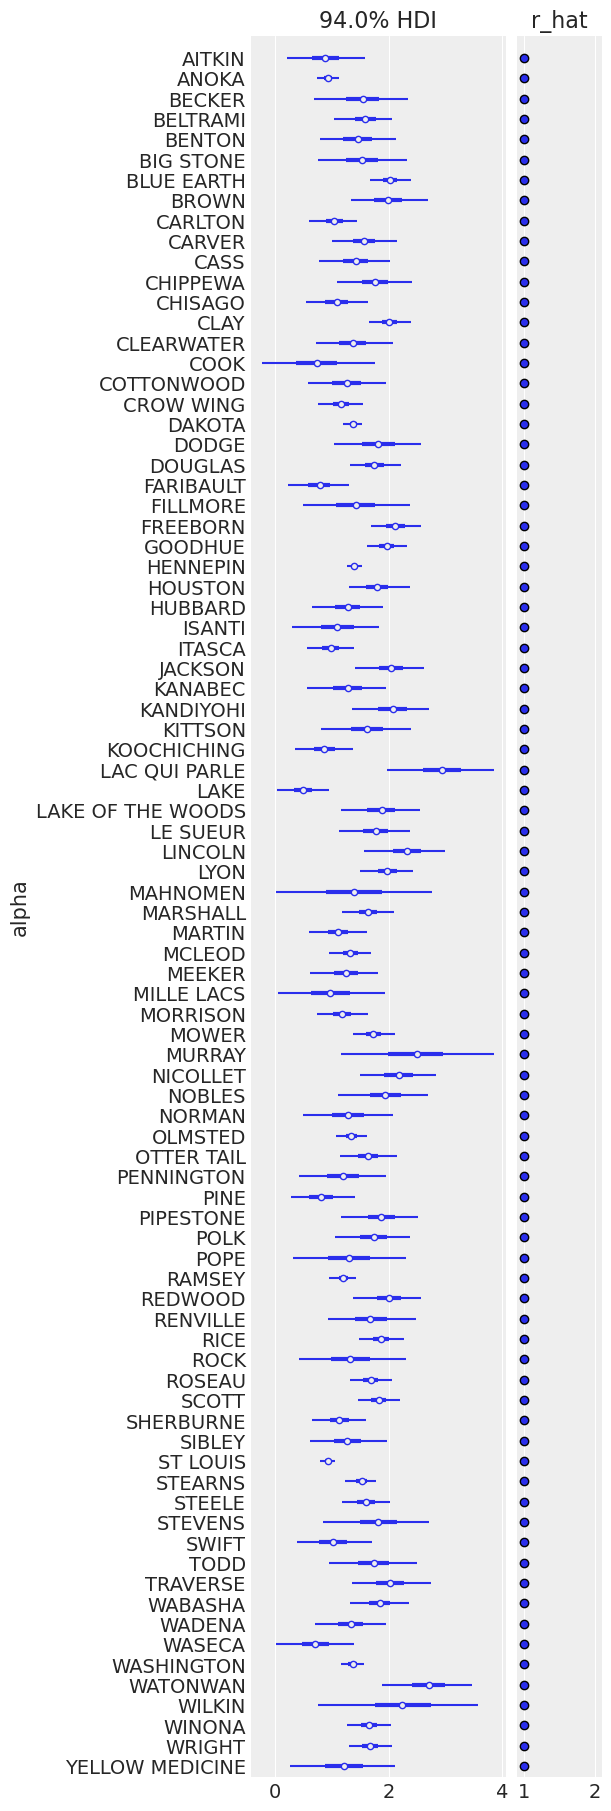

In [10]:
ax = az.plot_forest(
    unpooled_trace,
    var_names=["alpha"],
    r_hat=True,
    combined=True,
    figsize=(6, 18),
    labeller=az.labels.NoVarLabeller(),
)
ax[0].set_ylabel("alpha");

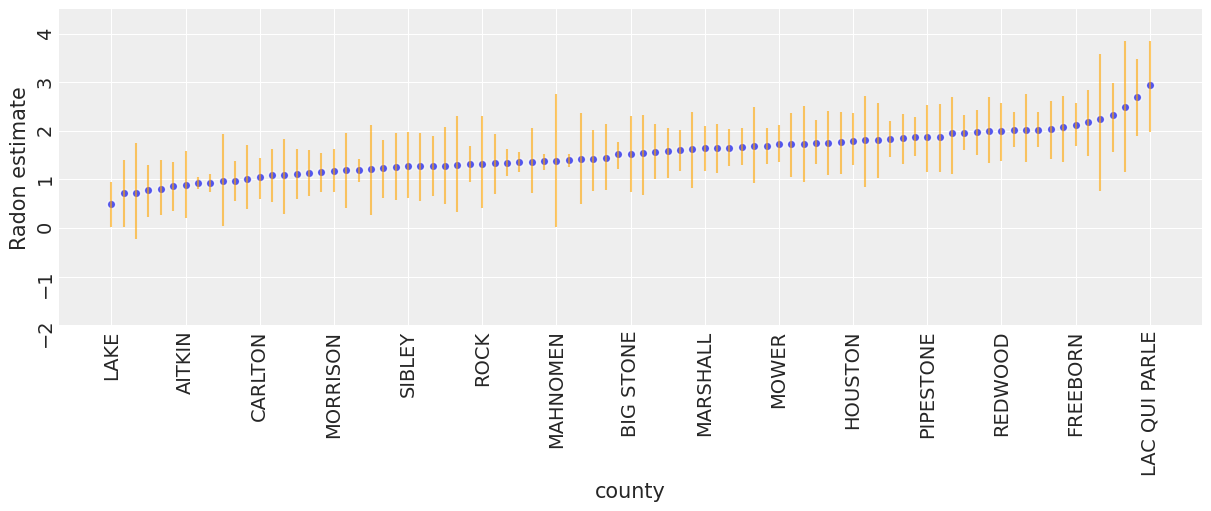

In [11]:
unpooled_means = unpooled_trace.posterior.mean(dim=("chain", "draw"))
unpooled_hdi = az.hdi(unpooled_trace)

unpooled_means_iter = unpooled_means.sortby("alpha")
unpooled_hdi_iter = unpooled_hdi.sortby(unpooled_means_iter.alpha)

_, ax = plt.subplots(figsize=(12, 5))
xticks = np.arange(0, 86, 6)
unpooled_means_iter.plot.scatter(x="county", y="alpha", ax=ax, alpha=0.8)
ax.vlines(
    np.arange(mn_counties.size),
    unpooled_hdi_iter.alpha.sel(hdi="lower"),
    unpooled_hdi_iter.alpha.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
)
ax.set(ylabel="Radon estimate", ylim=(-2, 4.5))
ax.set_xticks(xticks)
ax.set_xticklabels(unpooled_means_iter.county.values[xticks])
ax.tick_params(rotation=90);

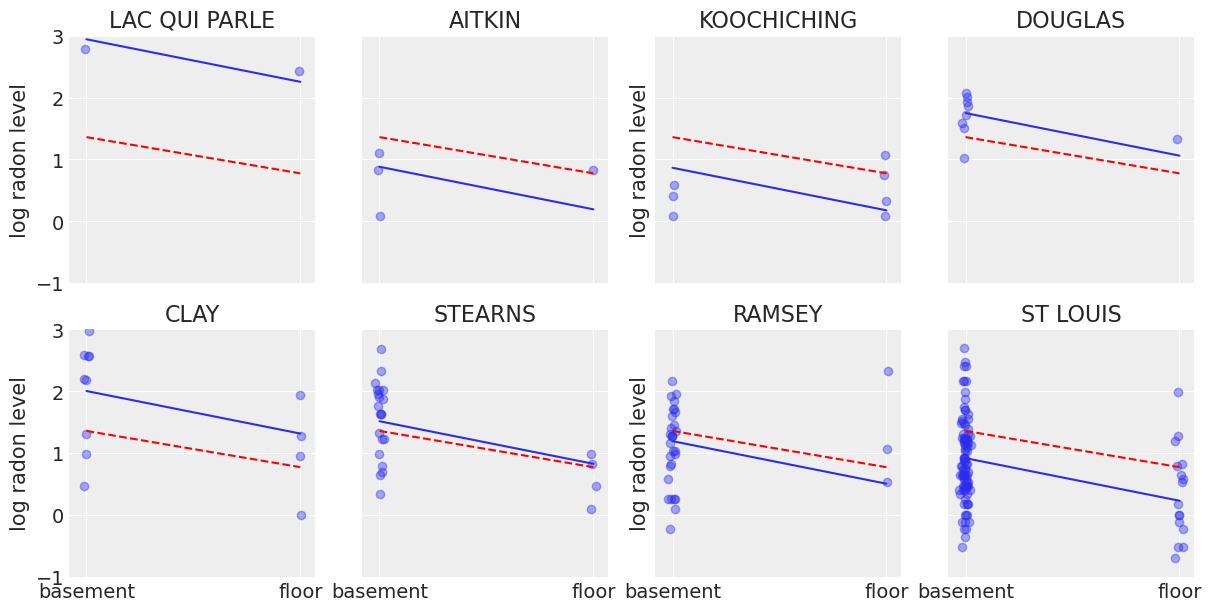

In [12]:
sample_counties = (
    "LAC QUI PARLE",
    "AITKIN",
    "KOOCHICHING",
    "DOUGLAS",
    "CLAY",
    "STEARNS",
    "RAMSEY",
    "ST LOUIS",
)

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_means["beta"]
for i, c in enumerate(sample_counties):
    y = srrs_mn.log_radon[srrs_mn.county == c]
    x = srrs_mn.floor[srrs_mn.county == c]
    axes[i].scatter(x + np.random.randn(len(x)) * 0.01, y, alpha=0.4)

    # No pooling model
    b = unpooled_means["alpha"].sel(county=c)

    # Plot both models and data
    xvals = xr.DataArray(np.linspace(0, 1))
    axes[i].plot(xvals, m * xvals + b)
    axes[i].plot(xvals, post_mean["beta"] * xvals + post_mean["alpha"], "r--")
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["basement", "floor"])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i % 2:
        axes[i].set_ylabel("log radon level")

- Partial Pooling

In [13]:
with pm.Model(coords=coords) as partial_pooling:
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10)
    sigma_a = pm.Exponential("sigma_a", 1)

    # Random intercepts
    alpha = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="county")

    # Model error
    sigma_y = pm.Exponential("sigma_y", 1)

    # Expected value
    y_hat = alpha[county_idx]

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_radon, dims="obs_id")

/opt/homebrew/anaconda3/envs/BayesianInference/lib/python3.10/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


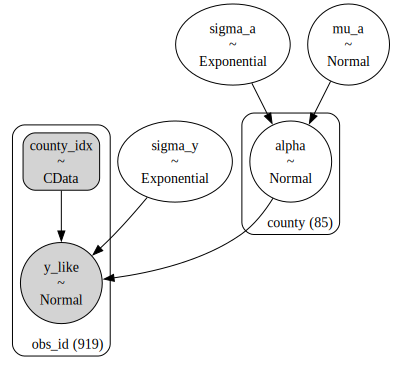

In [14]:
pm.model_to_graphviz(partial_pooling)

In [15]:
with partial_pooling:
    partial_pooling_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, alpha, sigma_y]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.


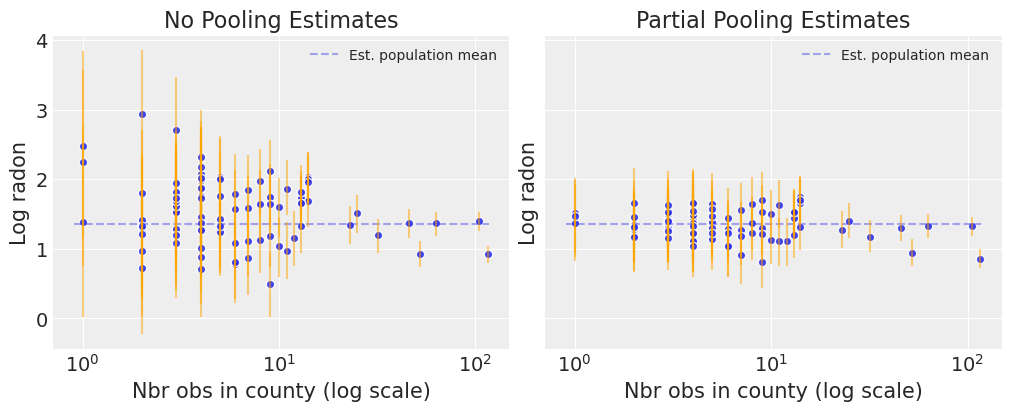

In [16]:
N_county = srrs_mn.groupby("county")["idnum"].count().values

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for ax, trace, level in zip(
    axes,
    (unpooled_trace, partial_pooling_trace),
    ("no pooling", "partial pooling"),
):
    # add variable with x values to xarray dataset
    trace.posterior = trace.posterior.assign_coords({"N_county": ("county", N_county)})
    # plot means
    trace.posterior.mean(dim=("chain", "draw")).plot.scatter(
        x="N_county", y="alpha", ax=ax, alpha=0.9
    )
    ax.hlines(
        partial_pooling_trace.posterior.alpha.mean(),
        0.9,
        max(N_county) + 1,
        alpha=0.4,
        ls="--",
        label="Est. population mean",
    )

    # plot hdi
    hdi = az.hdi(trace).alpha
    ax.vlines(N_county, hdi.sel(hdi="lower"), hdi.sel(hdi="higher"), color="orange", alpha=0.5)

    ax.set(
        title=f"{level.title()} Estimates",
        xlabel="Nbr obs in county (log scale)",
        xscale="log",
        ylabel="Log radon",
    )
    ax.legend(fontsize=10)

- Varying Intercept Model

In [3]:
with pm.Model(coords=coords) as varying_intercept:
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1)

    # Random intercepts
    alpha = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="county")
    # Common slope
    beta = pm.Normal("beta", mu=0.0, sigma=10.0)

    # Model error
    sd_y = pm.Exponential("sd_y", 1)

    # Expected value
    y_hat = alpha[county_idx] + beta * floor_idx

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sd_y, observed=log_radon, dims="obs_id")

/Users/mori/GIT/forMori/BayesianInference/basecamp/.venv/lib/python3.12/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


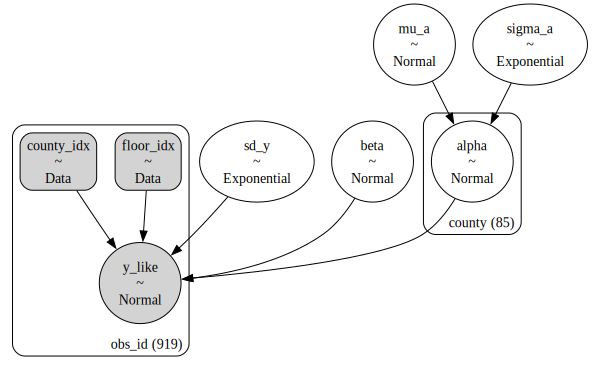

In [4]:
pm.model_to_graphviz(varying_intercept)

In [5]:
with varying_intercept:
    varying_intercept_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, alpha, beta, sd_y]


Output()

Text(0, 0.5, 'alpha')

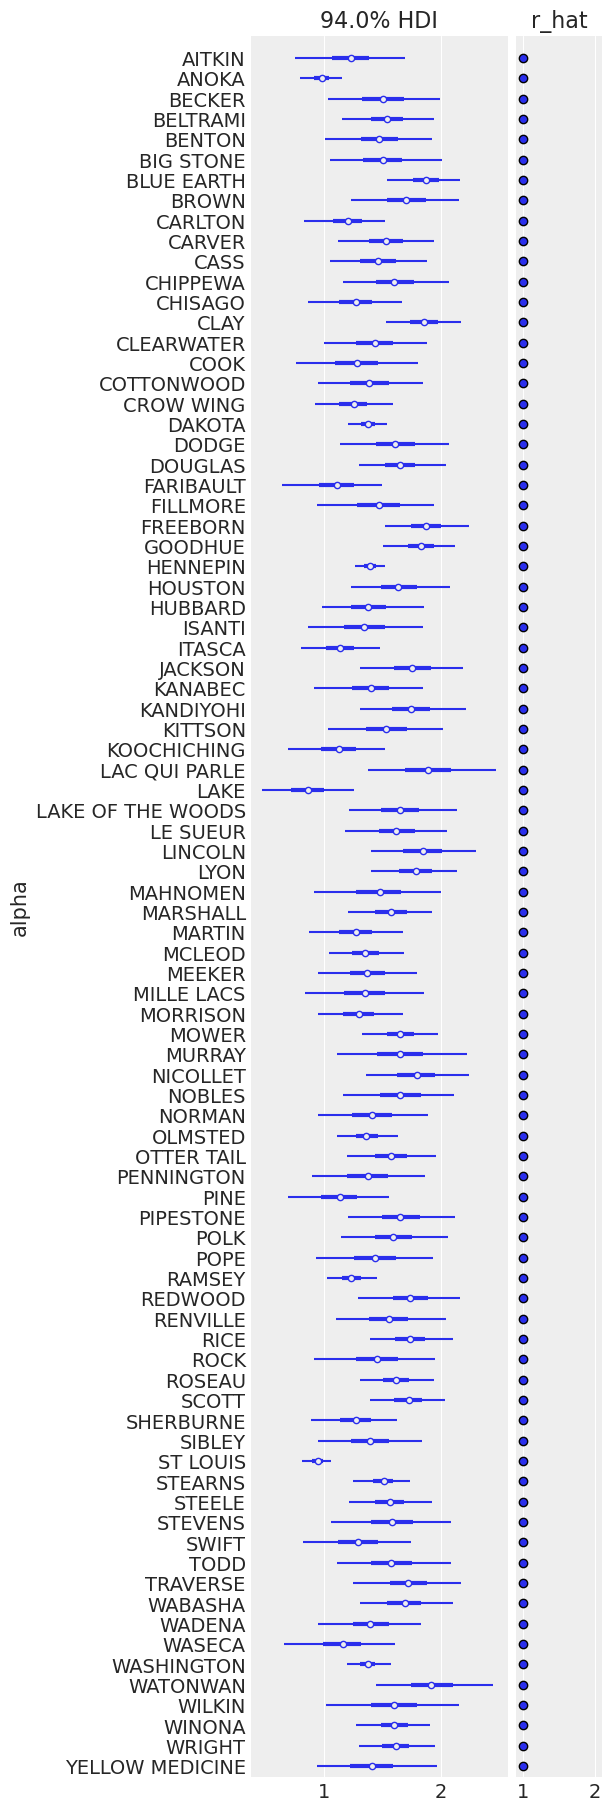

In [20]:
ax = pm.plot_forest(
    varying_intercept_trace,
    var_names=["alpha"],
    figsize=(6, 18),
    combined=True,
    r_hat=True,
    labeller=az.labels.NoVarLabeller(),
)
ax[0].set_ylabel("alpha")

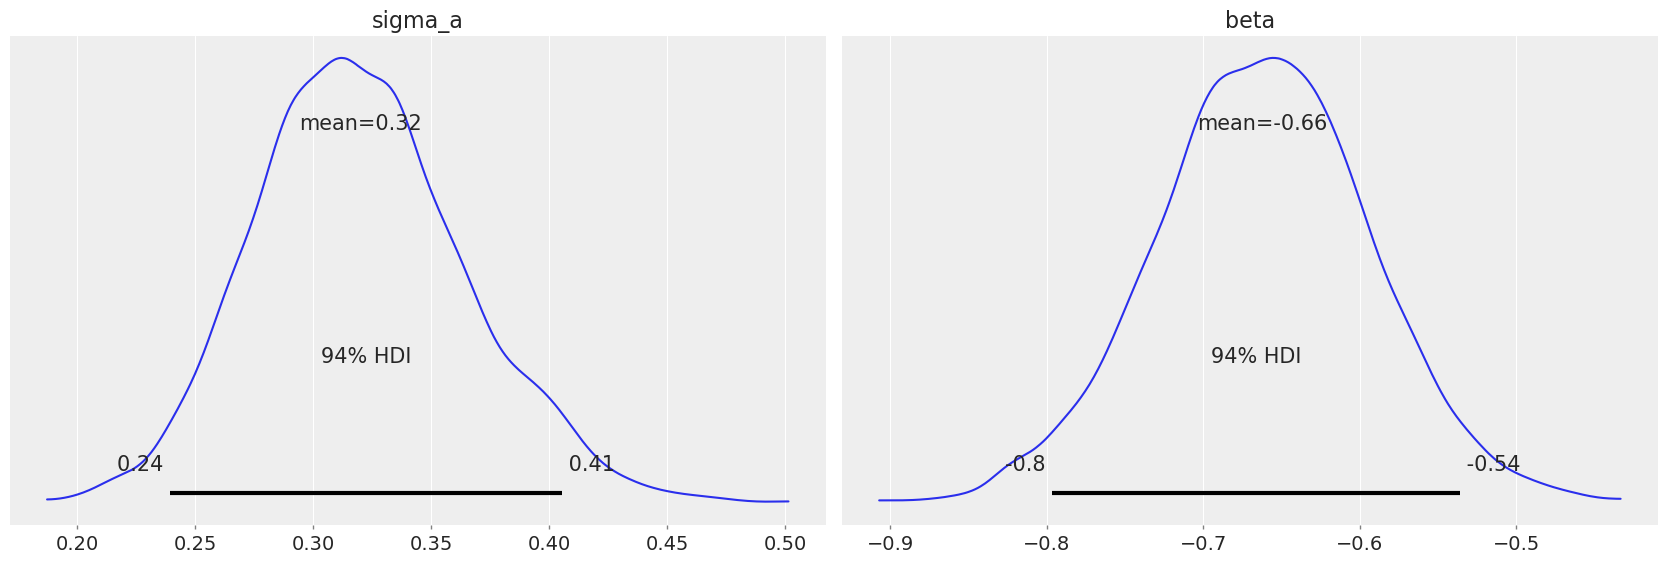

In [21]:
pm.plot_posterior(varying_intercept_trace, var_names=["sigma_a", "beta"]);

In [22]:
az.summary(varying_intercept_trace, var_names=["beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,-0.663,0.068,-0.797,-0.536,0.001,0.001,2317.0,2557.0,1.0


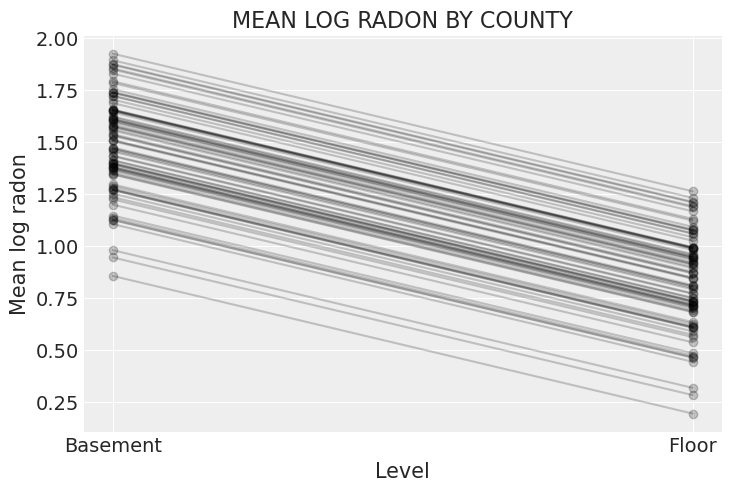

In [23]:
xvals = xr.DataArray([0, 1], dims="Level", coords={"Level": ["Basement", "Floor"]})
post = varying_intercept_trace.posterior  # alias for readability
theta = (
    (post.alpha + post.beta * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean log radon")
)

_, ax = plt.subplots()
theta.plot.scatter(x="Level", y="Mean log radon", alpha=0.2, color="k", ax=ax)  # scatter
ax.plot(xvals, theta["Mean log radon"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("MEAN LOG RADON BY COUNTY");

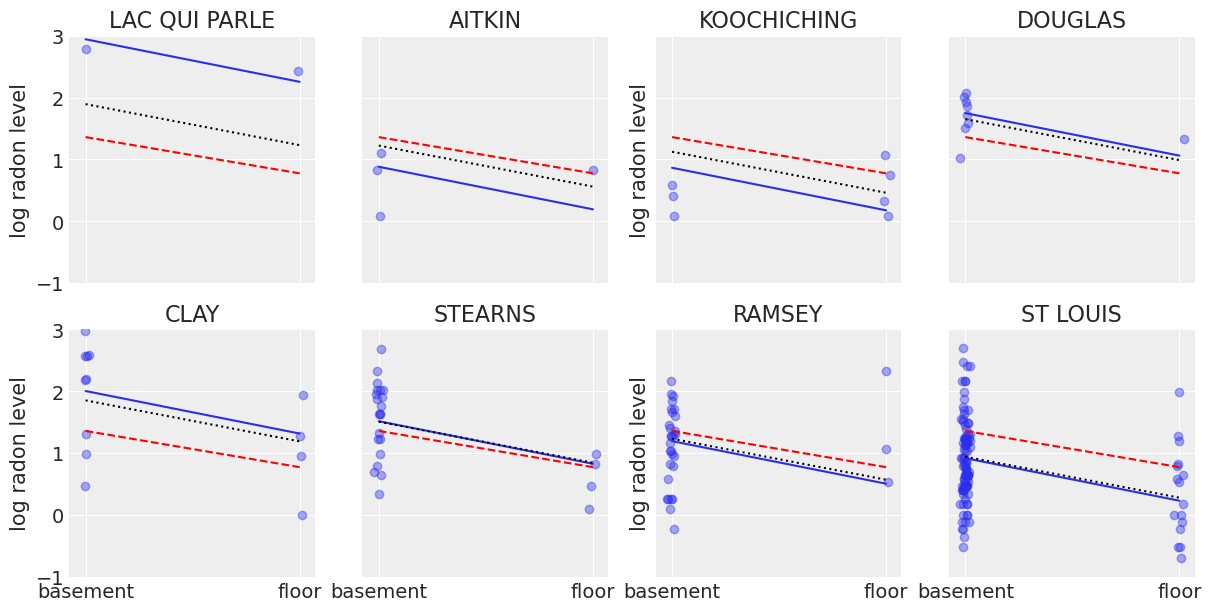

In [24]:
sample_counties = (
    "LAC QUI PARLE",
    "AITKIN",
    "KOOCHICHING",
    "DOUGLAS",
    "CLAY",
    "STEARNS",
    "RAMSEY",
    "ST LOUIS",
)

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_means["beta"]
for i, c in enumerate(sample_counties):
    y = srrs_mn.log_radon[srrs_mn.county == c]
    x = srrs_mn.floor[srrs_mn.county == c]
    axes[i].scatter(x + np.random.randn(len(x)) * 0.01, y, alpha=0.4)

    # No pooling model
    b = unpooled_means["alpha"].sel(county=c)

    # Plot both models and data
    xvals = xr.DataArray(np.linspace(0, 1))
    axes[i].plot(xvals, m.values * xvals + b.values)
    axes[i].plot(xvals, post_mean["beta"] * xvals + post_mean["alpha"], "r--")

    varying_intercept_trace.posterior.sel(county=c).beta
    post = varying_intercept_trace.posterior.sel(county=c).mean(dim=("chain", "draw"))
    theta = post.alpha.values + post.beta.values * xvals
    axes[i].plot(xvals, theta, "k:")
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["basement", "floor"])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i % 2:
        axes[i].set_ylabel("log radon level")

- Varying Intercept and Slope Model

In [25]:
with pm.Model(coords=coords) as varying_intercept_slope:
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1)

    mu_b = pm.Normal("mu_b", mu=0.0, sigma=10.0)
    sigma_b = pm.Exponential("sigma_b", 1)

    # Random intercepts
    alpha = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="county")
    # Random slopes
    beta = pm.Normal("beta", mu=mu_b, sigma=sigma_b, dims="county")

    # Model error
    sigma_y = pm.Exponential("sigma_y", 1)

    # Expected value
    y_hat = alpha[county_idx] + beta[county_idx] * floor_idx

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_radon, dims="obs_id")

/opt/homebrew/anaconda3/envs/BayesianInference/lib/python3.10/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


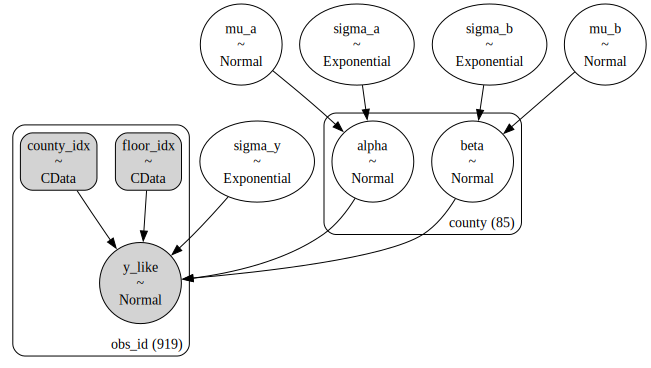

In [26]:
pm.model_to_graphviz(varying_intercept_slope)

In [27]:
with varying_intercept_slope:
    varying_intercept_slope_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, alpha, beta, sigma_y]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 8 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


- Non-Centered Parameterization

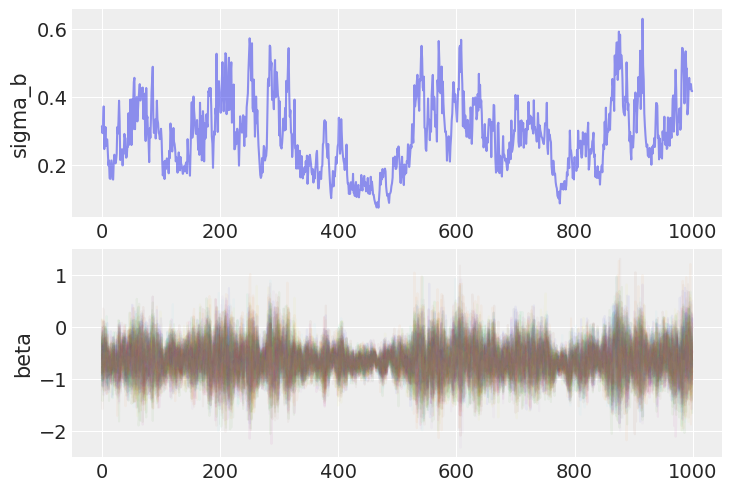

In [29]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(varying_intercept_slope_trace.posterior.sel(chain=0)["sigma_b"], alpha=0.5)
axs[0].set(ylabel="sigma_b")
axs[1].plot(varying_intercept_slope_trace.posterior.sel(chain=0)["beta"], alpha=0.05)
axs[1].set(ylabel="beta");

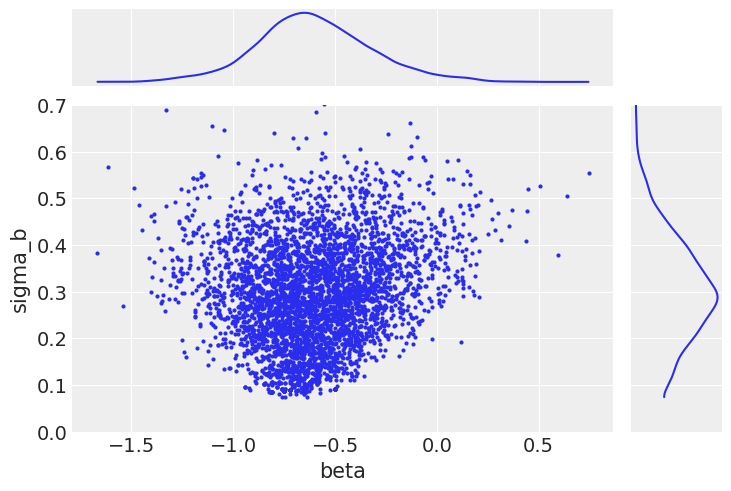

In [30]:
ax = az.plot_pair(
    varying_intercept_slope_trace,
    var_names=["beta", "sigma_b"],
    coords=dict(county="AITKIN"),
    marginals=True,
    # marginal_kwargs={"kind": "hist"},
)
ax[1, 0].set_ylim(0, 0.7);

In [31]:
with pm.Model(coords=coords) as varying_intercept_slope_noncentered:
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 5)

    # Non-centered random intercepts
    # Centered: a = pm.Normal('a', mu_a, sigma=sigma_a, shape=counties)
    z_a = pm.Normal("z_a", mu=0, sigma=1, dims="county")
    alpha = pm.Deterministic("alpha", mu_a + z_a * sigma_a, dims="county")

    mu_b = pm.Normal("mu_b", mu=0.0, sigma=10.0)
    sigma_b = pm.Exponential("sigma_b", 5)

    # Non-centered random slopes
    z_b = pm.Normal("z_b", mu=0, sigma=1, dims="county")
    beta = pm.Deterministic("beta", mu_b + z_b * sigma_b, dims="county")

    # Model error
    sigma_y = pm.Exponential("sigma_y", 5)

    # Expected value
    y_hat = alpha[county_idx] + beta[county_idx] * floor_idx

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_radon, dims="obs_id")

/opt/homebrew/anaconda3/envs/BayesianInference/lib/python3.10/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


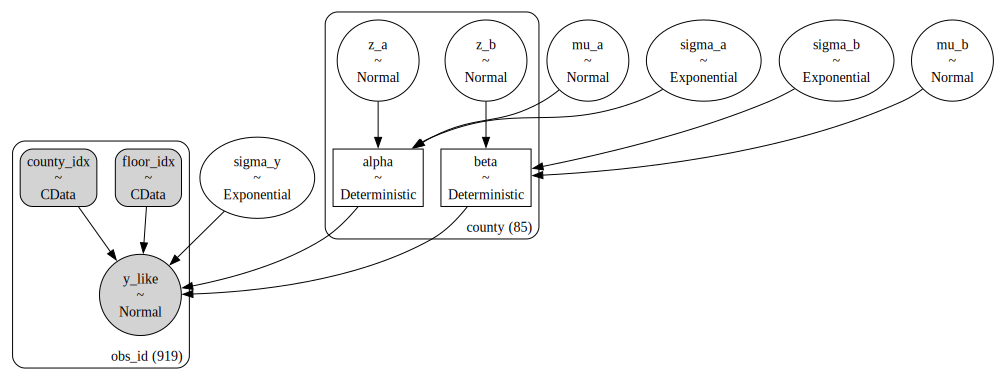

In [32]:
pm.model_to_graphviz(varying_intercept_slope_noncentered)

In [33]:
with varying_intercept_slope_noncentered:
    noncentered_trace = pm.sample(tune=3000, target_accept=0.95, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, z_a, mu_b, sigma_b, z_b, sigma_y]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 15 seconds.


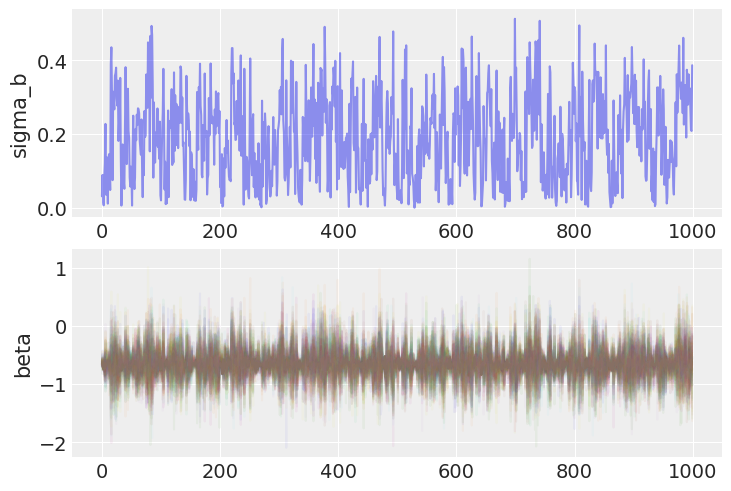

In [34]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(noncentered_trace.posterior.sel(chain=0)["sigma_b"], alpha=0.5)
axs[0].set(ylabel="sigma_b")
axs[1].plot(noncentered_trace.posterior.sel(chain=0)["beta"], alpha=0.05)
axs[1].set(ylabel="beta");

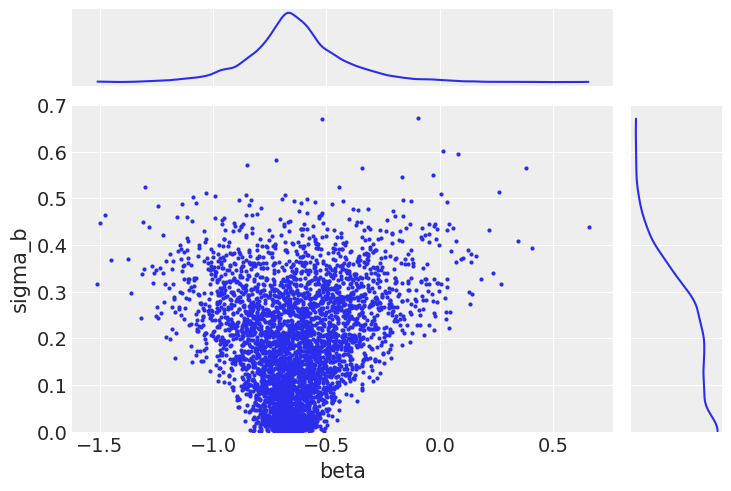

In [35]:
ax = az.plot_pair(
    noncentered_trace,
    var_names=["beta", "sigma_b"],
    coords=dict(county="AITKIN"),
    marginals=True,
    # marginal_kwargs={"kind": "hist"},
)
ax[1, 0].set_ylim(0, 0.7);

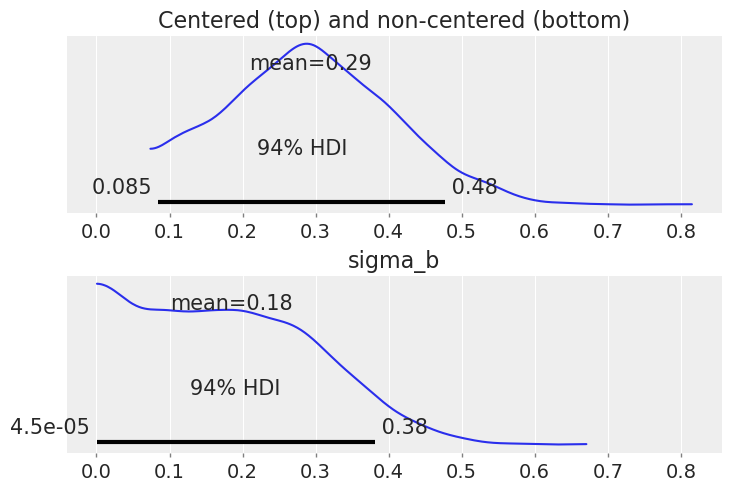

In [36]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, constrained_layout=True)
az.plot_posterior(varying_intercept_slope_trace, var_names=["sigma_b"], ax=ax1)
az.plot_posterior(noncentered_trace, var_names=["sigma_b"], ax=ax2)
ax1.set_title("Centered (top) and non-centered (bottom)");

In [37]:
az.summary(varying_intercept_slope_trace, var_names=["sigma_a", "sigma_b"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_a,0.326,0.046,0.241,0.407,0.002,0.001,827.0,1678.0,1.00
sigma_b,0.294,0.113,0.085,0.477,0.013,0.009,59.0,60.0,1.06


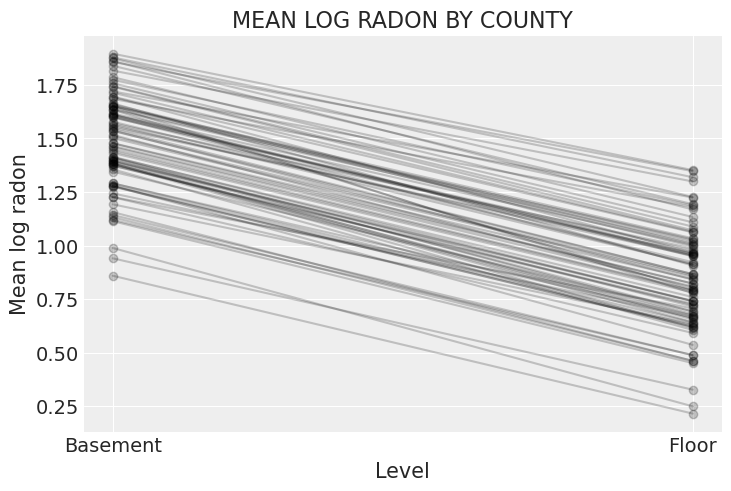

In [38]:
xvals = xr.DataArray([0, 1], dims="Level", coords={"Level": ["Basement", "Floor"]})
post = noncentered_trace.posterior  # alias for readability
theta = (
    (post.alpha + post.beta * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean log radon")
)

_, ax = plt.subplots()
theta.plot.scatter(x="Level", y="Mean log radon", alpha=0.2, color="k", ax=ax)  # scatter
ax.plot(xvals, theta["Mean log radon"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("MEAN LOG RADON BY COUNTY");

- Covariation_intercept_slope

In [5]:
coords["param"] = ["alpha", "beta"]
coords["param_bis"] = ["alpha", "beta"]
with pm.Model(coords=coords) as covariation_intercept_slope:
    floor_idx = pm.Data("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.Data("county_idx", county, dims="obs_id")

    # prior stddev in intercepts & slopes (variation across counties):
    sd_dist = pm.Exponential.dist(0.5, shape=(2,))

    # get back standard deviations and rho:
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=2.0, sd_dist=sd_dist)

    # prior for average intercept & slope:
    mu_alpha_beta = pm.Normal("mu_alpha_beta", mu=0.0, sigma=5.0, shape=2)
    # prior for average slope:
    # mu_beta = pm.Normal("mu_beta", mu=0.0, sigma=1.0)
    # population of varying effects:
    alpha_beta_county = pm.MvNormal(
        "alpha_beta_county", mu=mu_alpha_beta, chol=chol, dims=("county", "param")
    )

    # Expected value per county:
    theta = alpha_beta_county[county_idx, 0] + alpha_beta_county[county_idx, 1] * floor_idx
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

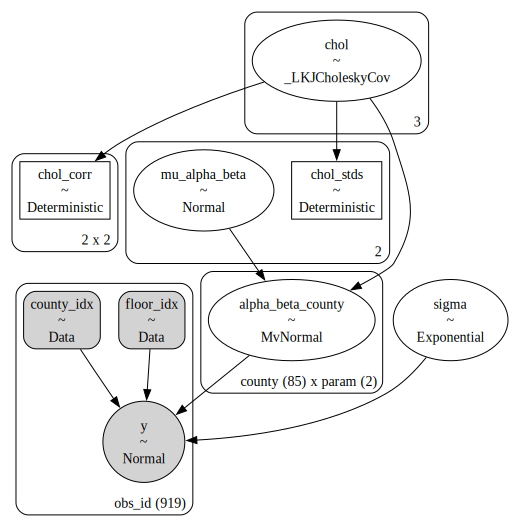

In [6]:
pm.model_to_graphviz(covariation_intercept_slope)

In [5]:
coords["param"] = ["alpha", "beta"]
coords["param_bis"] = ["alpha", "beta"]
with pm.Model(coords=coords) as covariation_intercept_slope:
    floor_idx = pm.Data("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.Data("county_idx", county, dims="obs_id")

    # prior stddev in intercepts & slopes (variation across counties):
    sd_dist = pm.Exponential.dist(0.5, shape=(2,))

    # get back standard deviations and rho:
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=2.0, sd_dist=sd_dist)

    # priors for average intercept and slope:
    mu_alpha_beta = pm.Normal("mu_alpha_beta", mu=0.0, sigma=5.0, shape=(2,))

    # population of varying effects:
    z = pm.Normal("z", 0.0, 1.0, dims=("param", "county"))
    alpha_beta_county = pm.Deterministic(
        "alpha_beta_county", pt.dot(chol, z).T, dims=("county", "param")
    )

    # Expected value per county:
    theta = (
        mu_alpha_beta[0]
        + alpha_beta_county[county_idx, 0]
        + (mu_alpha_beta[1] + alpha_beta_county[county_idx, 1]) * floor_idx
    )

    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

In [6]:
with covariation_intercept_slope:
    covariation_intercept_slope_trace = pm.sample(
        1000,
        tune=3000,
        target_accept=0.95,
        idata_kwargs={"dims": {"chol_stds": ["param"], "chol_corr": ["param", "param_bis"]}},
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol, mu_alpha_beta, z, sigma]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 23 seconds.


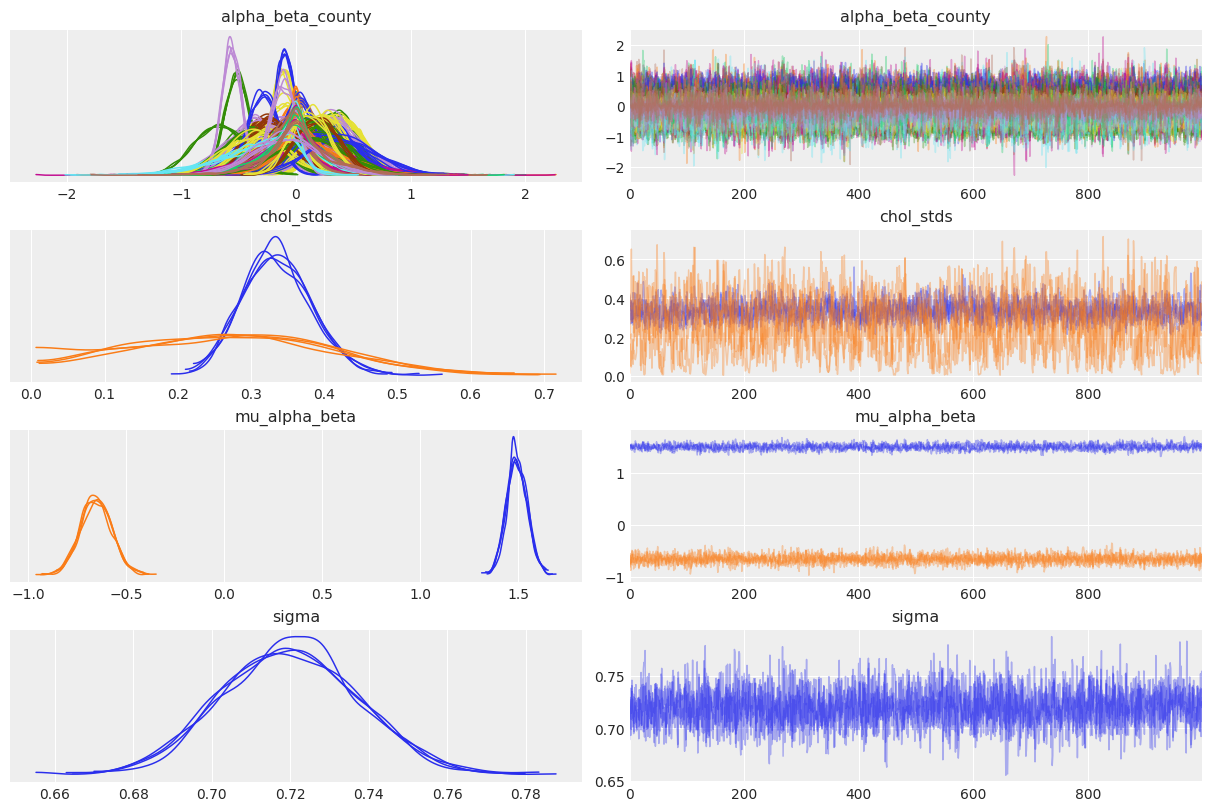

In [5]:
az.plot_trace(
    covariation_intercept_slope_trace,
    var_names=["~z", "~chol", "~chol_corr"],
    compact=True,
    chain_prop={"ls": "-"},
);

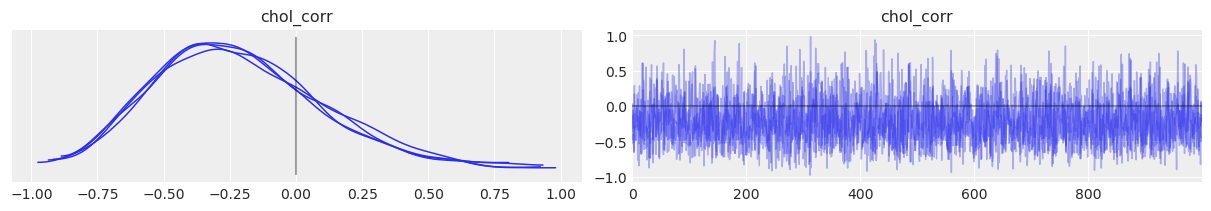

In [42]:
az.plot_trace(
    covariation_intercept_slope_trace,
    var_names="chol_corr",
    lines=[("chol_corr", {}, 0.0)],
    compact=True,
    chain_prop={"ls": "-"},
    coords={
        "param": xr.DataArray(["alpha"], dims=["pointwise_sel"]),
        "param_bis": xr.DataArray(["beta"], dims=["pointwise_sel"]),
    },
);

In [7]:
covariation_intercept_slope_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [9]:
xr.DataArray(["alpha"])

<xarray.DataArray (dim_0: 1)> Size: 20B
array(['alpha'], dtype='<U5')
Dimensions without coordinates: dim_0

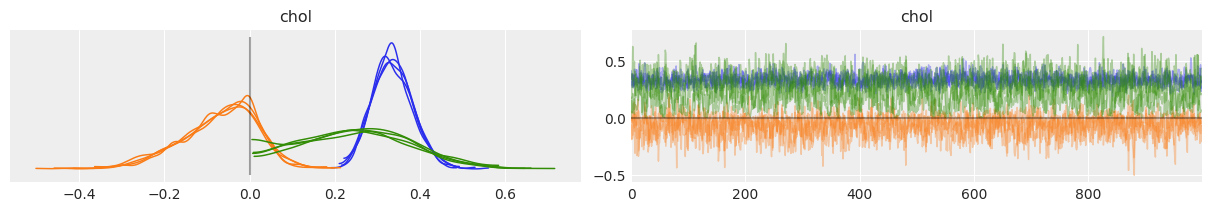

In [6]:
az.plot_trace(
    covariation_intercept_slope_trace,
    var_names="chol",
    lines=[("chol", {}, 0.0)],
    compact=True,
    chain_prop={"ls": "-"},
    coords={
        "param": xr.DataArray(["alpha"], dims=["pointwise_sel"]),
        "param_bis": xr.DataArray(["beta"], dims=["pointwise_sel"]),
    },
);

In [1]:
covariation_intercept_slope_trace

NameError: name 'covariation_intercept_slope_trace' is not defined

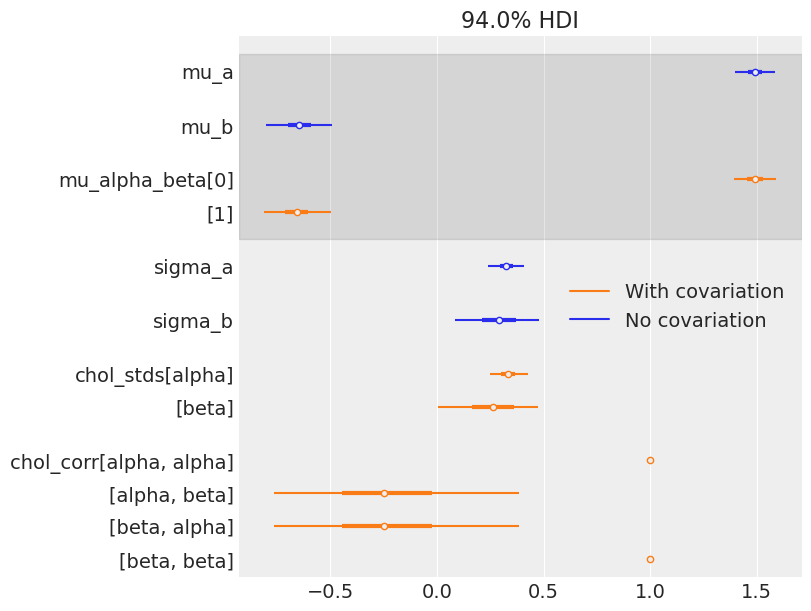

In [43]:
az.plot_forest(a
    [varying_intercept_slope_trace, covariation_intercept_slope_trace],
    model_names=["No covariation", "With covariation"],
    var_names=["mu_a", "mu_b", "mu_alpha_beta", "sigma_a", "sigma_b", "chol_stds", "chol_corr"],
    combined=True,
    figsize=(8, 6),
);

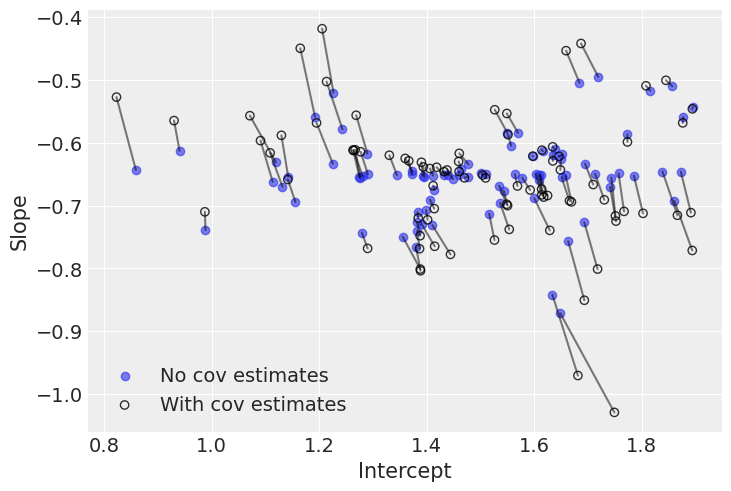

In [44]:
# posterior means of covariation model:
a_county_cov = (
    covariation_intercept_slope_trace.posterior["mu_alpha_beta"][..., 0]
    + covariation_intercept_slope_trace.posterior["alpha_beta_county"].sel(param="alpha")
).mean(dim=("chain", "draw"))
b_county_cov = (
    covariation_intercept_slope_trace.posterior["mu_alpha_beta"][..., 1]
    + covariation_intercept_slope_trace.posterior["alpha_beta_county"].sel(param="beta")
).mean(dim=("chain", "draw"))

# plot both and connect with lines
avg_a_county = noncentered_trace.posterior["alpha"].mean(dim=("chain", "draw"))
avg_b_county = noncentered_trace.posterior["beta"].mean(dim=("chain", "draw"))
plt.scatter(avg_a_county, avg_b_county, label="No cov estimates", alpha=0.6)
plt.scatter(
    a_county_cov,
    b_county_cov,
    facecolors="none",
    edgecolors="k",
    lw=1,
    label="With cov estimates",
    alpha=0.8,
)
plt.plot([avg_a_county, a_county_cov], [avg_b_county, b_county_cov], "k-", alpha=0.5)
plt.xlabel("Intercept")
plt.ylabel("Slope")
plt.legend();

- Hierarchical_intercept

In [7]:
with pm.Model(coords=coords) as hierarchical_intercept:
    # Priors
    sigma_a = pm.HalfCauchy("sigma_a", 5)

    # County uranium model
    gamma_0 = pm.Normal("gamma_0", mu=0.0, sigma=10.0)
    gamma_1 = pm.Normal("gamma_1", mu=0.0, sigma=10.0)

    # Uranium model for intercept
    mu_a = pm.Deterministic("mu_a", gamma_0 + gamma_1 * u)
    # County variation not explained by uranium
    epsilon_a = pm.Normal("epsilon_a", mu=0, sigma=1, dims="county")
    alpha = pm.Deterministic("alpha", mu_a + sigma_a * epsilon_a, dims="county")

    # Common slope
    beta = pm.Normal("beta", mu=0.0, sigma=10.0)

    # Model error
    sigma_y = pm.Uniform("sigma_y", lower=0, upper=100)

    # Expected value
    y_hat = alpha[county] + beta * floor_measure

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_radon)

In [8]:
pm.model_to_graphviz(hierarchical_intercept)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [47]:
with hierarchical_intercept:
    hierarchical_intercept_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, gamma_0, gamma_1, epsilon_a, beta, sigma_y]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 5 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.


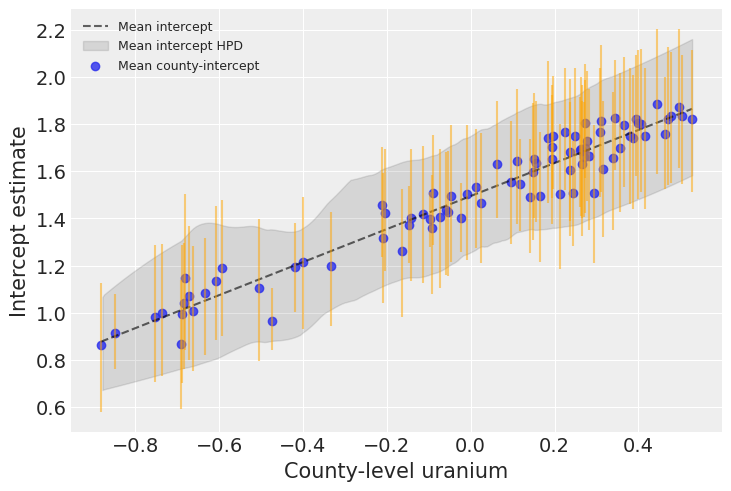

In [48]:
uranium = u
post = hierarchical_intercept_trace.posterior.assign_coords(uranium=uranium)
avg_a = post["mu_a"].mean(dim=("chain", "draw")).values[np.argsort(uranium)]
avg_a_county = post["alpha"].mean(dim=("chain", "draw"))
avg_a_county_hdi = az.hdi(post, var_names="alpha")["alpha"]

_, ax = plt.subplots()
ax.plot(uranium[np.argsort(uranium)], avg_a, "k--", alpha=0.6, label="Mean intercept")
az.plot_hdi(
    uranium,
    post["alpha"],
    fill_kwargs={"alpha": 0.1, "color": "k", "label": "Mean intercept HPD"},
    ax=ax,
)
ax.scatter(uranium, avg_a_county, alpha=0.8, label="Mean county-intercept")
ax.vlines(
    uranium,
    avg_a_county_hdi.sel(hdi="lower"),
    avg_a_county_hdi.sel(hdi="higher"),
    alpha=0.5,
    color="orange",
)
plt.xlabel("County-level uranium")
plt.ylabel("Intercept estimate")
plt.legend(fontsize=9);

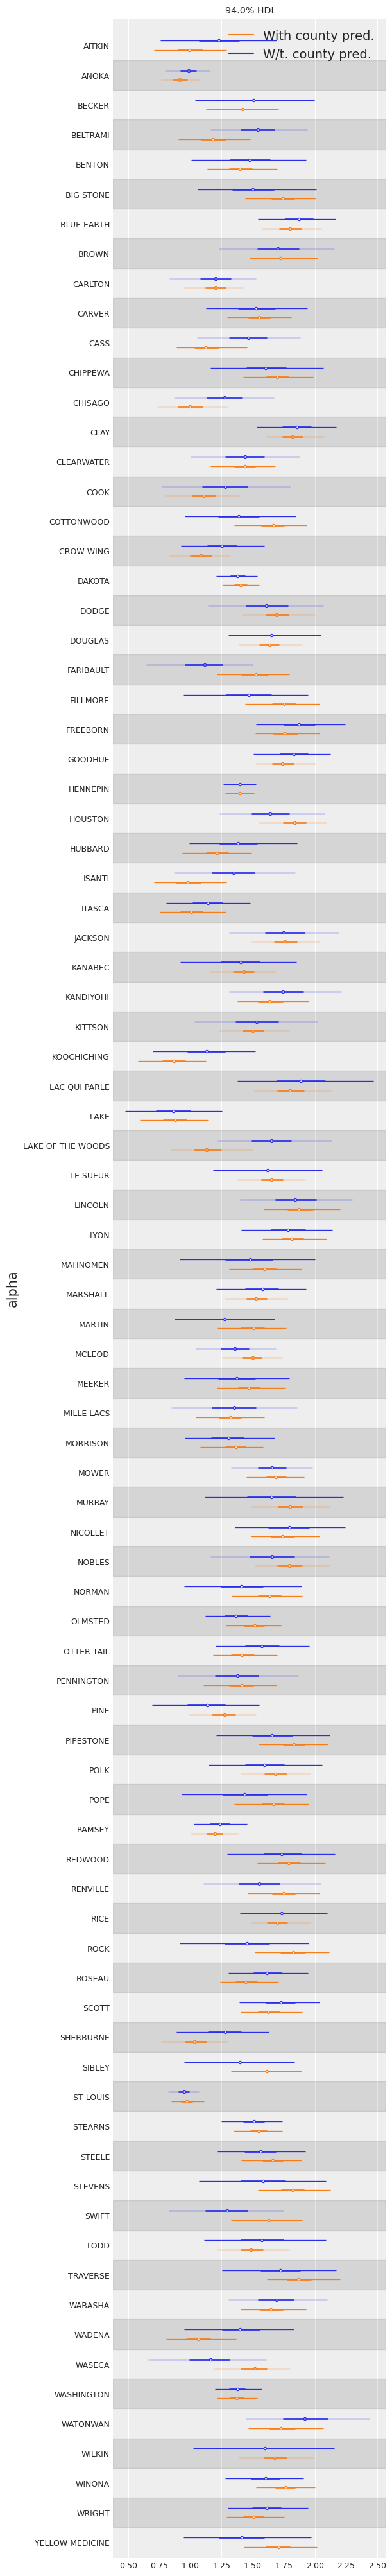

In [49]:
labeller = az.labels.mix_labellers((az.labels.NoVarLabeller, az.labels.NoModelLabeller))
ax = az.plot_forest(
    [varying_intercept_trace, hierarchical_intercept_trace],
    model_names=["W/t. county pred.", "With county pred."],
    var_names=["alpha"],
    combined=True,
    figsize=(6, 40),
    textsize=9,
    labeller=labeller(),
)
ax[0].set_ylabel("alpha");

In [ ]:
# Create new variable for mean of floor across counties
avg_floor_data = srrs_mn.groupby("county")["floor"].mean().values

- Contexual_effect

In [50]:
with pm.Model(coords=coords) as contextual_effect:
    floor_idx = pm.Data("floor_idx", floor_measure, mutable=True)
    county_idx = pm.Data("county_idx", county, mutable=True)
    y = pm.Data("y", log_radon, mutable=True)

    # Priors
    sigma_a = pm.HalfCauchy("sigma_a", 5)

    # County uranium model for slope
    gamma = pm.Normal("gamma", mu=0.0, sigma=10, shape=3)

    # Uranium model for intercept
    mu_a = pm.Deterministic("mu_a", gamma[0] + gamma[1] * u + gamma[2] * avg_floor_data)

    # County variation not explained by uranium
    epsilon_a = pm.Normal("epsilon_a", mu=0, sigma=1, dims="county")
    alpha = pm.Deterministic("alpha", mu_a + sigma_a * epsilon_a)

    # Common slope
    beta = pm.Normal("beta", mu=0.0, sigma=10)

    # Model error
    sigma_y = pm.Uniform("sigma_y", lower=0, upper=100)

    # Expected value
    y_hat = alpha[county_idx] + beta * floor_idx

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=y)

/opt/homebrew/anaconda3/envs/BayesianInference/lib/python3.10/site-packages/pymc/data.py:416: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


NameError: name 'avg_floor_data' is not defined

In [ ]:
with contextual_effect:
    contextual_effect_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

In [ ]:
az.summary(contextual_effect_trace, var_names="gamma", round_to=2)

In [ ]:
az.summary(contextual_effect_trace, var_names="gamma", round_to=2)

In [ ]:
prediction_coords = {"obs_id": ["ST LOUIS", "KANABEC"]}
with contextual_effect:
    pm.set_data({"county_idx": np.array([69, 31]), "floor_idx": np.array([1, 1]), "y": np.ones(2)})
    stl_pred = pm.sample_posterior_predictive(contextual_effect_trace.posterior)

contextual_effect_trace.extend(stl_pred)

In [ ]:
az.plot_posterior(contextual_effect_trace, group="posterior_predictive");